Example~2 in Paper "Modeling Epidemic Spread: A Gaussian Process Regression Approach"

In [2]:
import numpy as np
import gpflow
from gpflow.kernels import SquaredExponential
import matplotlib.pyplot as plt
from scipy.linalg import norm, inv
from gpflow.utilities import to_default_float
import matplotlib.dates as mdates
from datetime import datetime, timedelta

# Load the dataset
data = np.loadtxt('I_diff_7days_values_only.csv', delimiter=',')
#data = data[:300] 

# Parameters
T = 1
tau = 2.5
delta = 0.05
sigma_squared = 0.003

# Function to compute upper bound for the prediction
def compute_upper_bound(K, alpha_squared, beta, Y_train, sigma_squared, gamma, tau):
    n = K.shape[0]
    I_n = np.eye(n)
    L_k = 0.01
    L_m = (alpha_squared / (beta * np.exp(0.5))) * np.sqrt(n) * np.linalg.norm(np.linalg.inv(K + sigma_squared * I_n) @ Y_train)
    L_s = (2 * n * alpha_squared**2 / (beta * np.exp(0.5))) * norm(np.linalg.inv(K + sigma_squared * I_n), 2)
    kxi = (L_k + L_m) * tau + np.sqrt(gamma * L_s * tau)
    return kxi

# Initialize lists to store bounds, differences, means, and variances
bounds = []
differences = []
all_means = []
all_variances = []
mean_indices = []  # To store the corresponding indices of predictions
within_95_ci = 0  # Counter for points within 95% confidence interval

# Compute gamma
gamma = 2 * (np.log(T / (2 * tau * delta)) + 1 / delta)

# Train and predict using an increasing window size with 30 training data points each time
for start_idx in range(30, len(data) - 20, 20):  # Moving window of size 5
    train_idx = np.arange(start_idx - 30, start_idx)
    test_idx = np.arange(start_idx, start_idx + 20)
    
    X_train = train_idx.reshape(-1, 1).astype(np.float64)
    Y_train = data[train_idx].reshape(-1, 1).astype(np.float64)
    
    X_test = test_idx.reshape(-1, 1).astype(np.float64)
    Y_test = data[test_idx].reshape(-1, 1).astype(np.float64)
    
    # Define the Squared Exponential kernel
    kernel = SquaredExponential()
    
    # Define the GP model
    model_I = gpflow.models.GPR(
        data=(X_train, Y_train),
        kernel=kernel,
        likelihood=gpflow.likelihoods.Gaussian(variance_lower_bound=sigma_squared)
    )
    
    # Set up the optimizer
    opt = gpflow.optimizers.Scipy()
    
    # Train the model
    opt.minimize(model_I.training_loss, model_I.trainable_variables)
    
    # After training, extract the learned alpha_squared (variance) and beta (lengthscale)
    alpha_squared = model_I.kernel.variance.numpy()
    beta = model_I.kernel.lengthscales.numpy()
    
    # Predict at the test locations
    I_mean, I_var = model_I.predict_f(X_test)
    
    # Store the means and variances for plotting
    all_means.append(I_mean.numpy().flatten())
    all_variances.append(np.sqrt(I_var.numpy().flatten()))
    mean_indices.extend(test_idx)  # Keep track of the indices of the predictions
    
    # Compute the posterior variance
    K = kernel(X_train).numpy()  # Recompute K for the current training set
    for i, t_star in enumerate(test_idx):
        K_star = kernel(np.array([[t_star]]), X_train).numpy()
        K_star_star = kernel(np.array([[t_star]]), np.array([[t_star]])).numpy()
        sigma_t_star_squared = K_star_star - K_star @ inv(K + sigma_squared * np.eye(len(X_train))) @ K_star.T
        
        # Compute the upper bound
        Bound = np.sqrt(gamma) * np.sqrt(sigma_t_star_squared) + compute_upper_bound(K, alpha_squared, beta, Y_train, sigma_squared, gamma, tau)
        bounds.append(Bound[0][0])
        
        # Compute the difference between the posterior mean and the true value
        difference = abs(I_mean.numpy()[i, 0] - Y_test[i, 0])
        differences.append(difference)

        # Check if the true value is within the 95% confidence interval
        lower_bound = I_mean.numpy()[i, 0] - 1.96 * np.sqrt(I_var.numpy()[i, 0])
        upper_bound = I_mean.numpy()[i, 0] + 1.96 * np.sqrt(I_var.numpy()[i, 0])
        if lower_bound <= Y_test[i, 0] <= upper_bound:
            within_95_ci += 1

# Convert lists to arrays for easier plotting
all_means = np.concatenate(all_means)
all_variances = np.concatenate(all_variances)
mean_indices = np.array(mean_indices)



Percentage of points within the 95% confidence interval: 94.29%


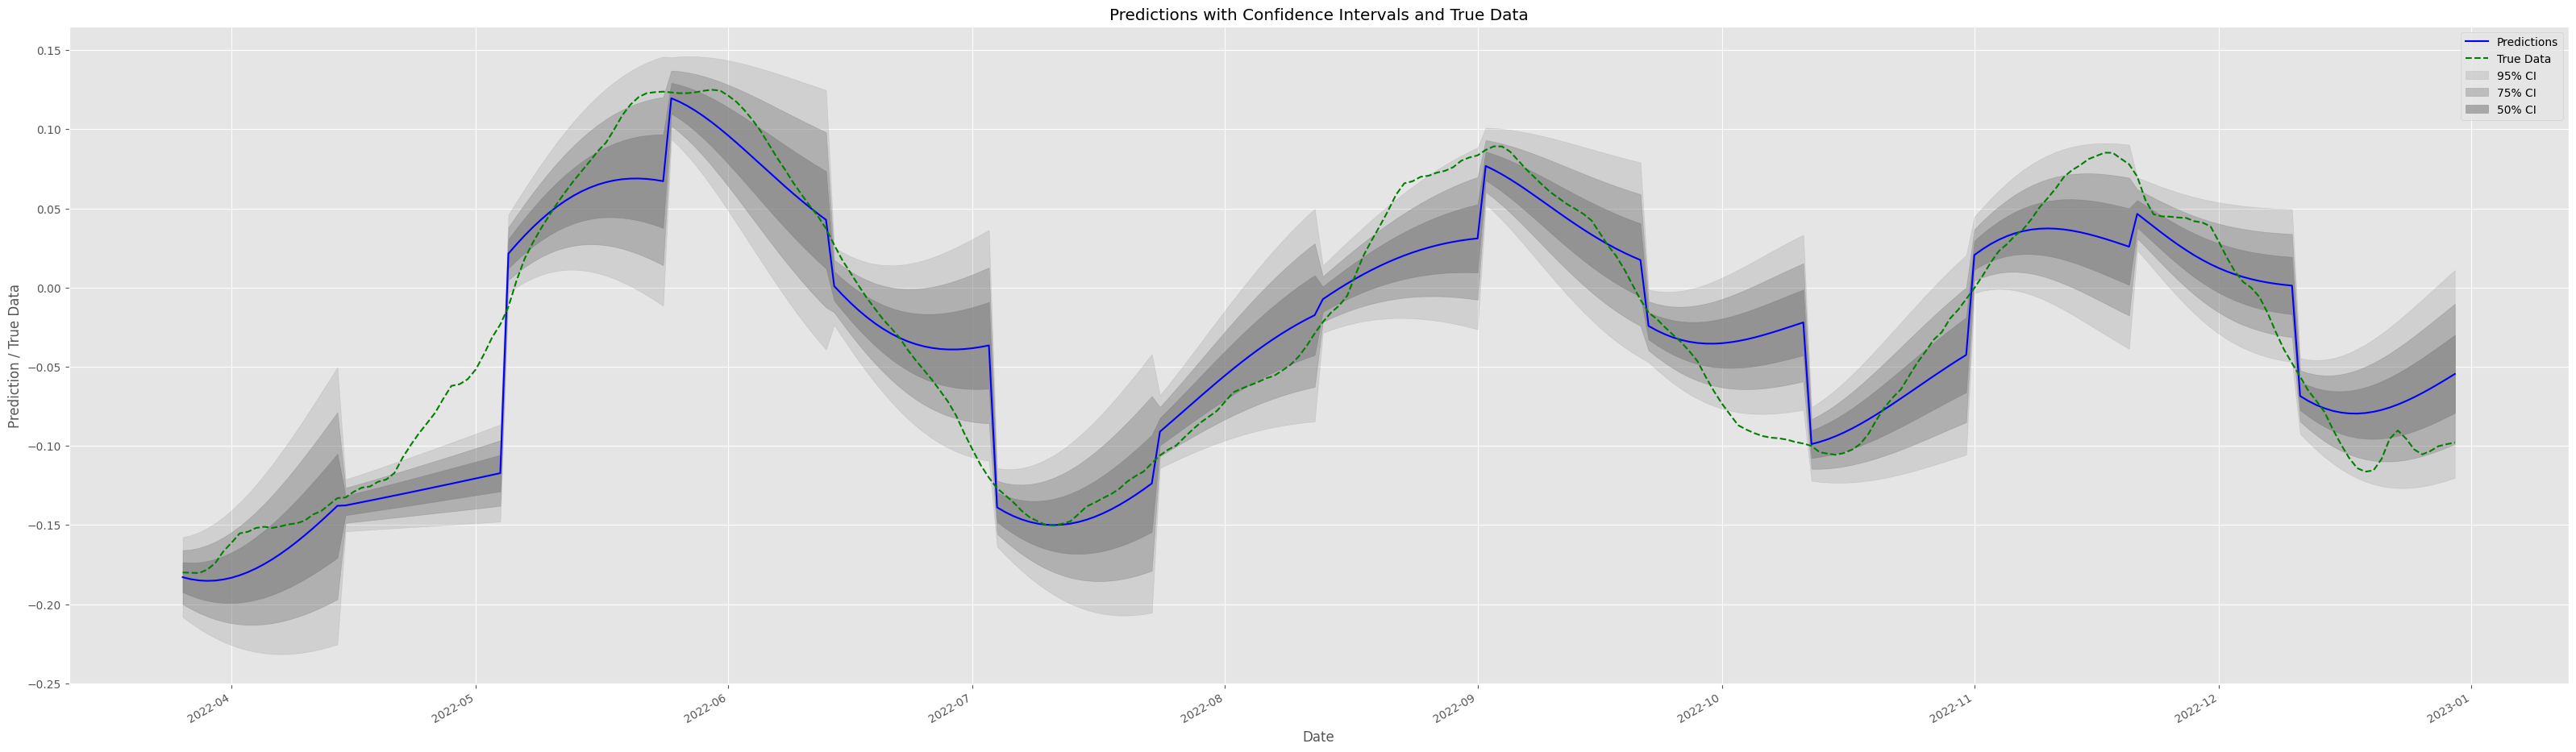

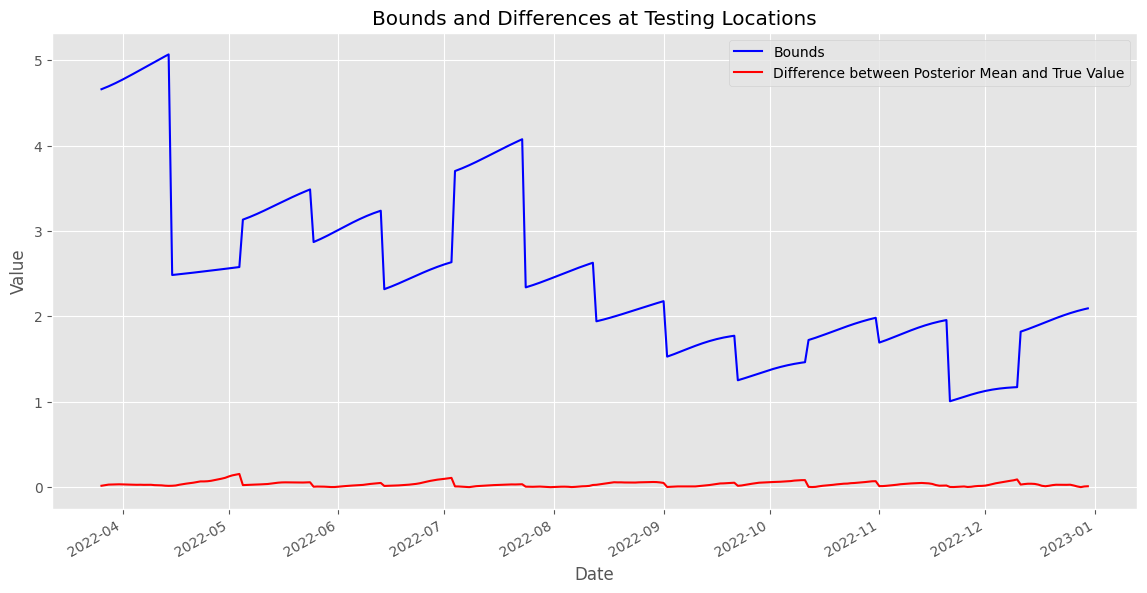

In [3]:
# Shift mean indices 5 points earlier
mean_indices_shifted = mean_indices -5

# Create date labels starting from "03-01-2022"
start_date = datetime(2022, 3, 1)
date_labels = [start_date + timedelta(days=int(i)) for i in mean_indices_shifted]  # Convert np.int32 to int

# Calculate the percentage of points within the 95% confidence interval
total_points = len(all_means)
percent_within_95_ci = (within_95_ci / total_points) * 100

print(f"Percentage of points within the 95% confidence interval: {percent_within_95_ci:.2f}%")

plt.style.use('ggplot')
# Plotting the prediction and true values
plt.figure(figsize=(40, 12))
plt.plot(date_labels, all_means, color='blue', label='Predictions')
plt.plot(date_labels, data[mean_indices_shifted], color='green', linestyle='--', label='True Data')

# Plotting confidence intervals
plt.fill_between(date_labels, all_means - all_variances, all_means + all_variances, color='gray', alpha=0.2, label='95% CI')
plt.fill_between(date_labels, all_means - 0.675 * all_variances, all_means + 0.675 * all_variances, color='gray', alpha=0.4, label='75% CI')
plt.fill_between(date_labels, all_means - 0.375 * all_variances, all_means + 0.375 * all_variances, color='gray', alpha=0.6, label='50% CI')

plt.xlabel('Date')
plt.ylabel('Prediction / True Data')
plt.title('Predictions with Confidence Intervals and True Data')
plt.gcf().autofmt_xdate()  # Rotate date labels
plt.legend()
plt.show()

# Plotting the bounds and differences
plt.figure(figsize=(14, 7))
plt.plot(date_labels, bounds, label='Bounds', color='blue')
plt.plot(date_labels, differences, label='Difference between Posterior Mean and True Value', color='red')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Bounds and Differences at Testing Locations')
plt.gcf().autofmt_xdate()  # Rotate date labels
plt.legend()
plt.show()


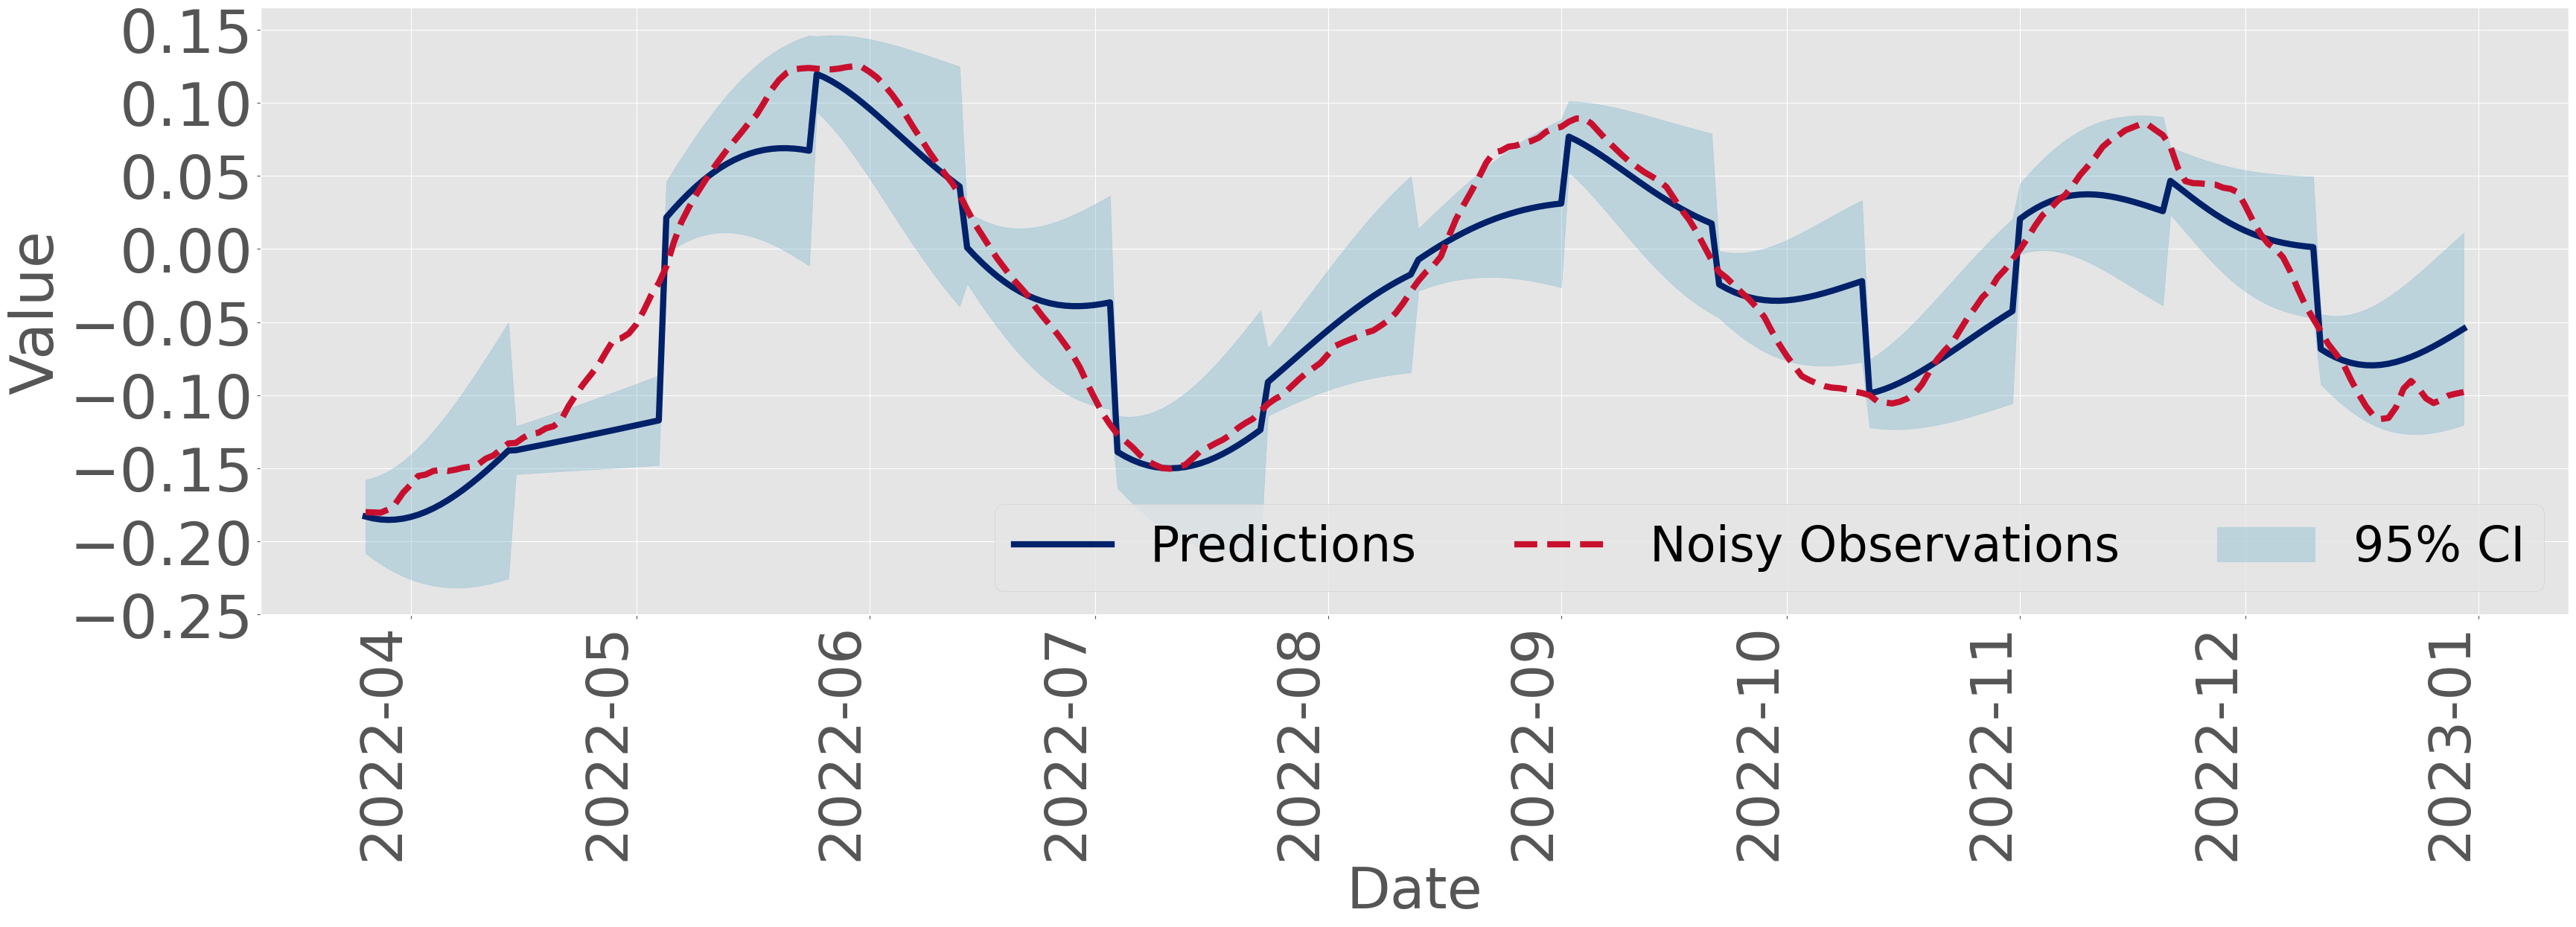

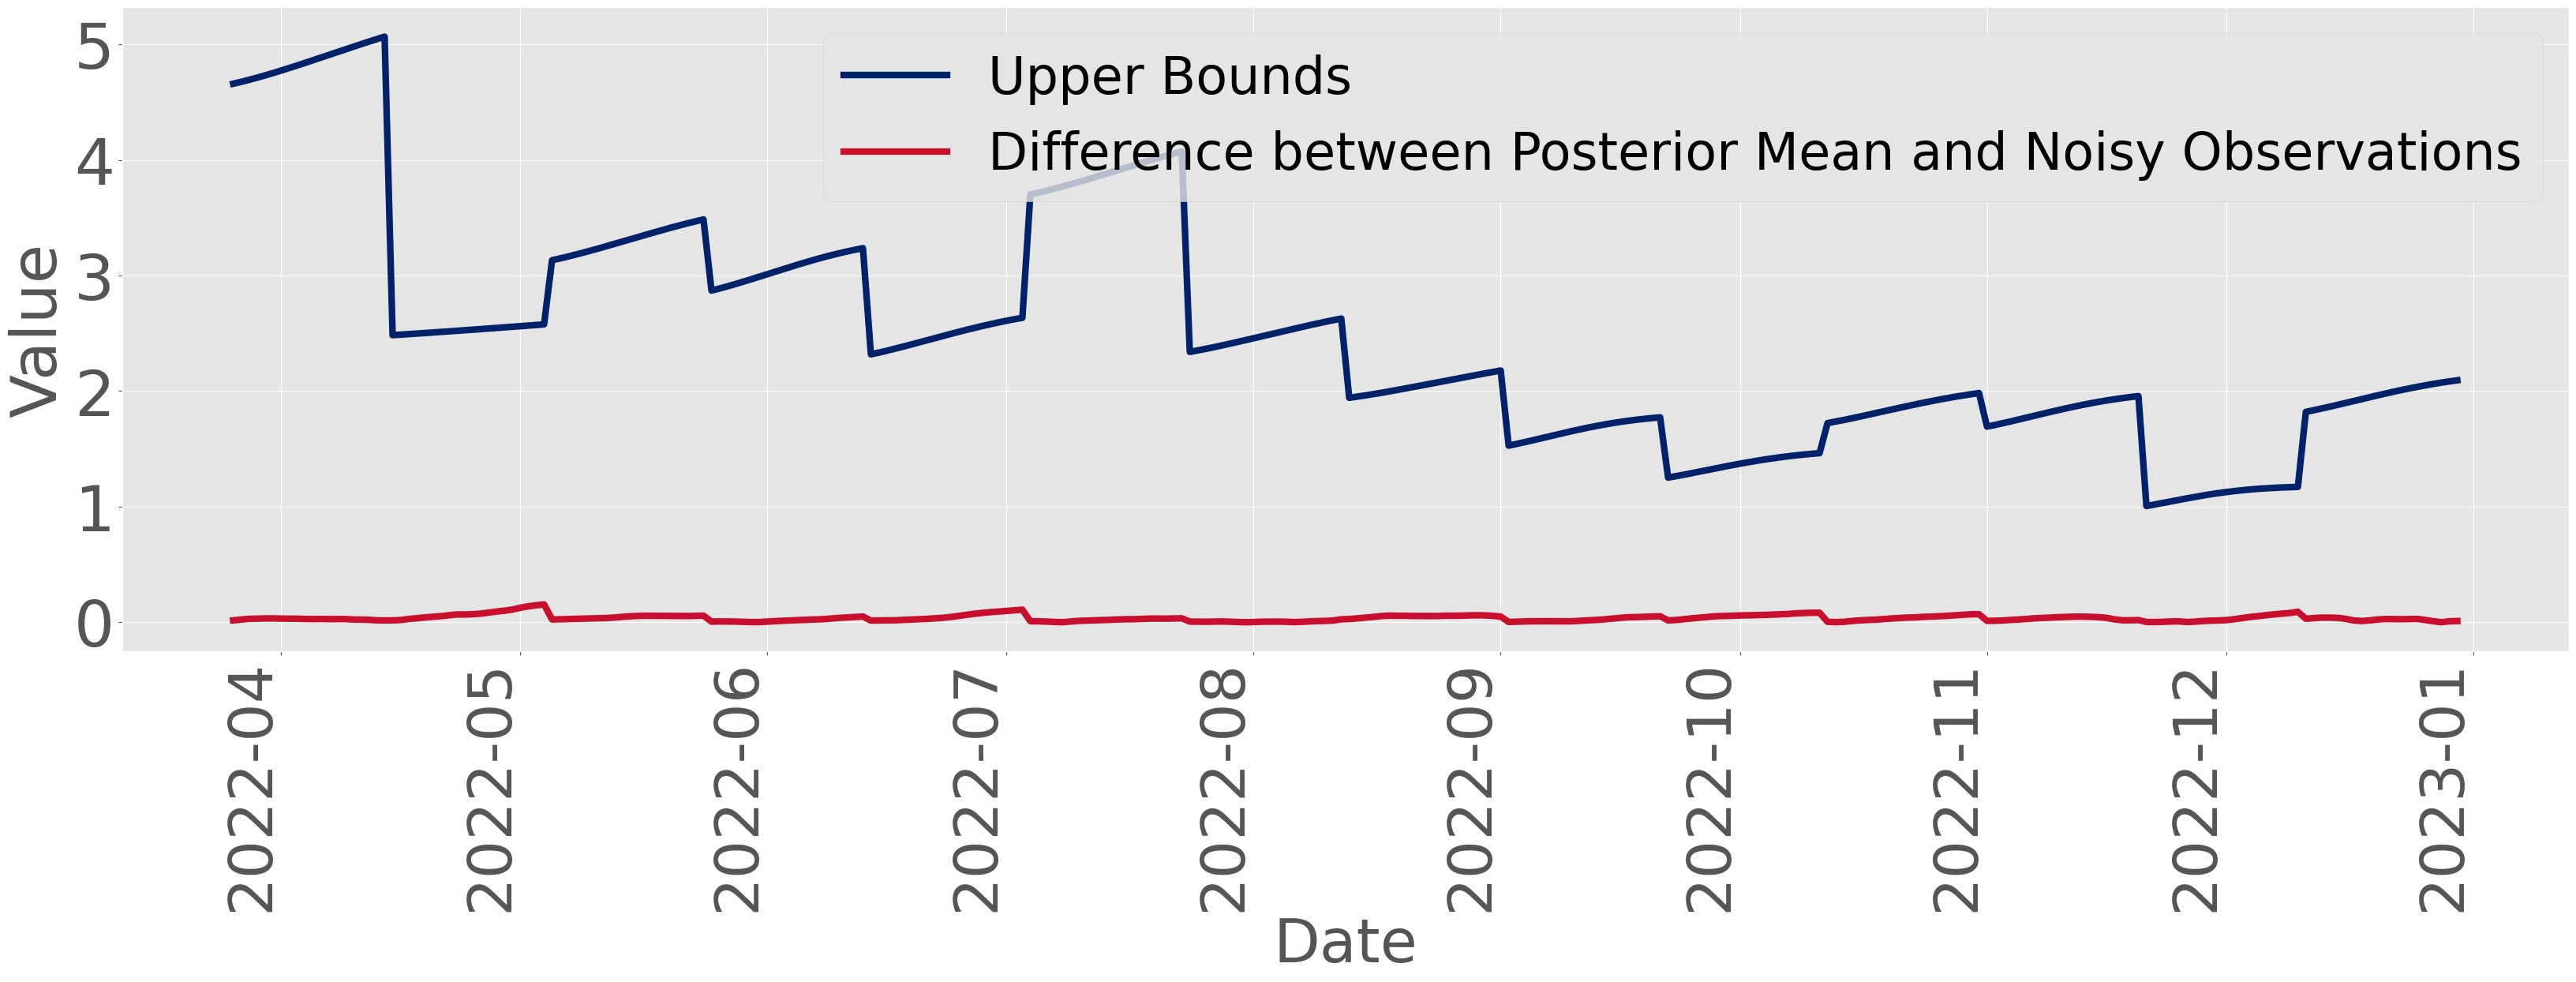

In [4]:
plt.style.use('ggplot')
# Plotting the prediction and true values
plt.figure(figsize=(40, 12))
plt.plot(date_labels, all_means, color=(1/255, 33/255, 105/255), label='Predictions', linewidth = 6)
plt.plot(date_labels, data[mean_indices_shifted], color=(200/255, 16/255, 46/255), linestyle='--', label='Noisy Observations', linewidth = 6)

# Plotting confidence intervals
plt.fill_between(date_labels, all_means - all_variances, all_means + all_variances, color='#74b3ce', alpha=0.35, label='95% CI')
#plt.fill_between(date_labels, all_means - 0.675 * all_variances, all_means + 0.675 * all_variances, color='gray', alpha=0.4, label='75% CI')
#plt.fill_between(date_labels, all_means - 0.375 * all_variances, all_means + 0.375 * all_variances, color='gray', alpha=0.6, label='50% CI')

plt.xlabel('Date',fontsize = 55)
plt.ylabel('Value',fontsize = 58)
#plt.title('Posterior Mean with Confidence Intervals and True Data',fontsize = 40)
plt.gcf().autofmt_xdate()  # Rotate date labels
plt.xticks(rotation=90)
plt.xticks(fontsize = 55)
plt.yticks(fontsize = 58)
plt.legend(fontsize = 47, ncol=3)
plt.savefig('Prediction.png', dpi=150, bbox_inches='tight')
plt.show()

# Plotting the bounds and differences
plt.figure(figsize=(40,12))
plt.plot(date_labels, bounds, label='Upper Bounds', color=(1/255, 33/255, 105/255), linewidth = 6)
plt.plot(date_labels, differences, label='Difference between Posterior Mean and Noisy Observations', color=(200/255, 16/255, 46/255), linewidth = 6)
plt.xlabel('Date',fontsize = 55)
plt.ylabel('Value',fontsize = 58)
#plt.title('Bounds and Differences at Testing Locations',fontsize = 40)
plt.gcf().autofmt_xdate()  # Rotate date labels
plt.xticks(rotation=90)
plt.xticks(fontsize = 55)
plt.yticks(fontsize = 58)
plt.legend(fontsize = 47)
plt.savefig('Upper_Bound.png', dpi=150, bbox_inches='tight')
plt.show()
